# Imports

In [1]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn    import metrics
from lightgbm   import LGBMClassifier

from BorutaShap import BorutaShap

from scipy.stats import ks_2samp

from sklearn.inspection        import permutation_importance
from sklearn.preprocessing     import QuantileTransformer
from sklearn.model_selection   import train_test_split, cross_validate
from sklearn.feature_selection import SelectFromModel

/home/junior/.venv/dstoolkit/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

pd.options.display.max_columns = None
pd.options.display.max_rows = 2000

In [3]:
def get_dimensions(df):

    print("Number of Rows: {}".format(df.shape[0]))
    print("NUmber of Cols: {}".format(df.shape[1]))

# Loading Datasets

In [4]:
df = pd.read_csv('../data/raw/cardio.csv', sep=';').drop(['id'], axis=1)
new_columns = {"ap_hi": "systolic_blood_pressure", "ap_lo": "diastolic_blood_pressure", "gluc": "glucose", "smoke": "smoking", "alco": "alcohol", "active": "physical_activity", "cardio": "disease"}

df.rename(columns=new_columns, inplace=True)

target = 'disease'

X = df.drop([target], axis=1)
y = df.loc[:, [target]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# Machine Learning

## LightGBM CV

In [5]:
def get_classification_metrics(y, col_target='target', col_pred='pred', col_prob='prob', decimals=0):

    """
    Function to calculate the regression metrics: R2, RMSE, MAE, MAPE, MedAE

    Parameters
    ----------
    y : DataFrame
        Data frame with target and prediction.

    col_target : str
        The name of the columns with the target.

    col_pred : str
        The name of the columns with the prediction.

    decimals : int
        Number of decimal places to round.
    
    Returns
    -------
    dict_results : Dict
        Dictionary with metric results.
    """

    auc = metrics.roc_auc_score(y[col_target], y[col_prob])

    ks = ks_2samp(y.loc[y[col_target] == 0, col_prob], y.loc[y[col_target] == 1, col_prob]).statistic

    dict_results = {"ROC AUC": np.round(auc, decimals), "KS": np.round(ks, decimals)}

    return dict_results

In [6]:
def select_from_model(estimator, X_train, y_train, target='target', threshold=None, max_features=None):

    sfm = SelectFromModel(estimator, threshold=threshold, max_features=max_features)
    sfm.fit(X_train, y_train[target])

    list_selected_features = X_train.loc[:, sfm.get_support()].columns.tolist()

    return list_selected_features

In [7]:
def fit_lgbm_classifier_cv(X_train, y_train, X_test, y_test, target, selected_features=None, cv=3, params=None, random_state=42):

    if selected_features:

        X_train = X_train.loc[:, selected_features]
        X_test = X_test.loc[:, selected_features]

    cat_columns = X_train.select_dtypes(include='object')

    if any(cat_columns):

        print('---------------> Feature Engineering')
        
        X_train[cat_columns] = X_train[cat_columns].astype("category")
        X_test[cat_columns] = X_test[cat_columns].astype("category")

    print('---------------> Modeling')

    init_params = {'verbosity': -1, 'random_state': random_state, 'n_jobs': -1}
    
    if params:
        
        init_params.update(params)

    model = LGBMClassifier(**init_params)

    list_class_metrics = ['roc_auc']

    cv_results = cross_validate(estimator=model, X=X_train, y=y_train[target], cv=cv, scoring=list_class_metrics)

    auc_mean = np.round(cv_results['test_roc_auc'].mean(), 4)

    model.fit(X_train, y_train[target])
    y_test['prob'] = model.predict_proba(X_test)[:, 1]

    dict_results = get_classification_metrics(y_test, target, decimals=4)
    
    auc, ks = dict_results['ROC AUC'], dict_results['KS']

    print('---------------> Metrics')

    print(f"Cross Validation  ROC AUC: {auc_mean}, KS: -")
    print(f"Test  Validation  ROC AUC: {auc}, KS: {ks}")

    return model

In [8]:
def boruta_shap_classification(
        X_train, y_train, model=None, target='target', n_trials=100, sample=False, train_or_test='test', normalize=True, verbose=False):
    
    boruta_shap = BorutaShap(model, importance_measure='shap', classification=True)
    boruta_shap.fit(
        X=X_train, y=y_train[target], n_trials=n_trials, sample=sample, 
        train_or_test=train_or_test, normalize=normalize, verbose=verbose)

    list_selected_features = boruta_shap.Subset().columns.tolist()
    
    return list_selected_features

In [9]:
def tune_params_lgbm_classifier_cv(
    X_train, y_train, selected_features=None, n_trials=100, target='target', scoring='roc_auc', direction='maximize', random_state=42):
    
    if selected_features:

        X_train = X_train.loc[:, selected_features]

    def objective(trial):
    
        param = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": -1,
            "n_jobs": -1,
            "random_state": random_state,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)
        }
        
        cv_results = cross_validate(
            estimator=LGBMClassifier(**param), scoring=scoring, cv=3, X=X_train, y=y_train[target])
    
        score_mean = cv_results['test_score'].mean()
    
        return score_mean
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)

    best_params = {"objective": "binary", "metric": "binary_logloss", "verbosity": -1, "n_jobs": -1, "random_state": random_state}
    best_params.update(study.best_params)
    
    return best_params

In [10]:
def get_tree_feature_importance(model, X, selected_features=None):
    
    if selected_features:

        X = X.loc[:, selected_features]

    df_imp = pd.DataFrame(model.feature_importances_, X.columns).reset_index()
    df_imp.columns = ["Variable", "Importance"]
    df_imp = df_imp.sort_values("Importance", ascending=False)
    
    sns.barplot(x="Importance", y="Variable", color="#006e9cff", data=df_imp[:20])
    
    plt.title(f"Importance of Variables")
    plt.show()

    return df_imp

In [11]:
def get_tree_summary_plot(model, X, selected_features=None):

    if selected_features:

        X = X.loc[:, selected_features]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    shap.summary_plot(shap_values, X)

In [12]:
def get_permutation_importance(model, X, y, scoring, target='target', selected_features=None, random_state=42, n_repeats=5):

    if selected_features:

        X = X.loc[:, selected_features]

    dict_results = permutation_importance(
        estimator=model, X=X, y=y[target], scoring=scoring, random_state=random_state, n_repeats=n_repeats, n_jobs=-1)

    sorted_importances_idx = dict_results.importances_mean.argsort()
    
    df_results = pd.DataFrame(dict_results.importances[sorted_importances_idx].T, columns=X.columns[sorted_importances_idx])
    
    ax = df_results.plot.box(vert=False, whis=10)
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    
    plt.show()

    return df_results

In [13]:
def automl_lgbm_classifier_cv(
    X_train, y_train, X_test, y_test, selection_method='sfm', target='target', cv=3, n_trials=100, scoring='roc_auc', direction='maximize', random_state=42):

    dict_results = {}
    
    print('--------> Standard Model')

    standard_model = fit_lgbm_classifier_cv(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, selected_features=None, target=target, cv=cv, random_state=random_state)

    dict_results['standard_model'] = standard_model

    if selection_method == 'sfm':

        print('\n--------> Feature Selection', '\n---------------> Select From Model')
        
        list_selected_features = select_from_model(
            estimator=LGBMClassifier(verbosity=-1, random_state=random_state, n_jobs=-1), X_train=X_train, y_train=y_train, target=target)

        dict_results['selected_features'] = list_selected_features

        selected_features_model = fit_lgbm_classifier_cv(
            X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
            selected_features=list_selected_features, target=target, cv=cv, random_state=random_state)
        
        dict_results['selected_features_model'] = selected_features_model
    
    elif selection_method == 'boruta':

        print('\n--------> Feature Selection', '\n---------------> Boruta Shap')

        list_selected_features = boruta_shap_classification(
            X_train=X_train, y_train=y_train, model=LGBMClassifier(verbosity=-1, random_state=random_state, n_jobs=-1), 
            n_trials=100, sample=False, train_or_test='test', normalize=True, verbose=False, target=target)

        dict_results['selected_features'] = list_selected_features

        selected_features_model = fit_lgbm_classifier_cv(
            X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
            selected_features=list_selected_features, target=target, cv=cv, random_state=random_state)

        dict_results['selected_features_model'] = selected_features_model

    else:

        list_selected_features = None
    
    print('\n--------> Hyperparameter Tuning')
    
    params = tune_params_lgbm_classifier_cv(
        X_train, y_train, selected_features=list_selected_features, n_trials=n_trials, target=target, scoring=scoring, direction=direction, random_state=random_state)

    dict_results['best_params'] = params
    
    model = fit_lgbm_classifier_cv(
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, params=params,
        selected_features=list_selected_features, target=target, cv=cv, random_state=random_state)

    dict_results['model'] = model
    
    print('\n--------> Feature Importance')
    
    df_imp = get_tree_feature_importance(model, X_train, selected_features=list_selected_features)

    dict_results['feature_importance'] = df_imp

    print('\n--------> Permutation Importance')

    df_perm = get_permutation_importance(model, X, y, target=target, selected_features=list_selected_features, scoring=scoring, random_state=random_state, n_repeats=5)

    dict_results['permutation_importance'] = df_perm
    
    print('\n--------> Shap Values')
    
    get_tree_summary_plot(model, X_train, selected_features=list_selected_features)

    return dict_results

--------> Standard Model
---------------> Modeling
---------------> Metrics
Cross Validation  ROC AUC: 0.8014, KS: -
Test  Validation  ROC AUC: 0.8072, KS: 0.492

--------> Hyperparameter Tuning
---------------> Modeling
---------------> Metrics
Cross Validation  ROC AUC: 0.8011, KS: -
Test  Validation  ROC AUC: 0.8081, KS: 0.5

--------> Feature Importance


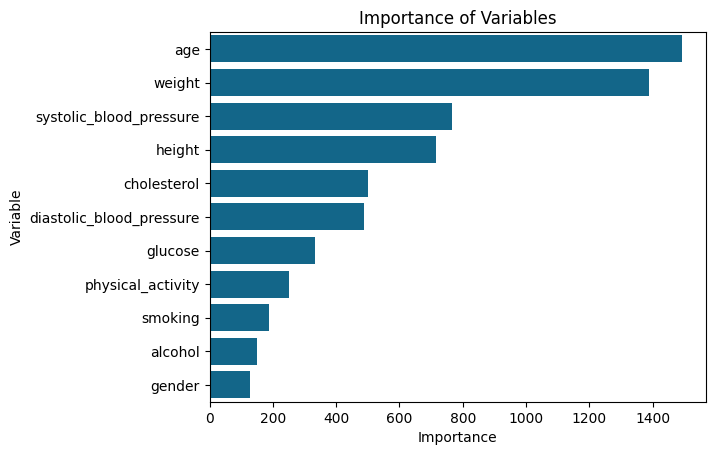


--------> Permutation Importance


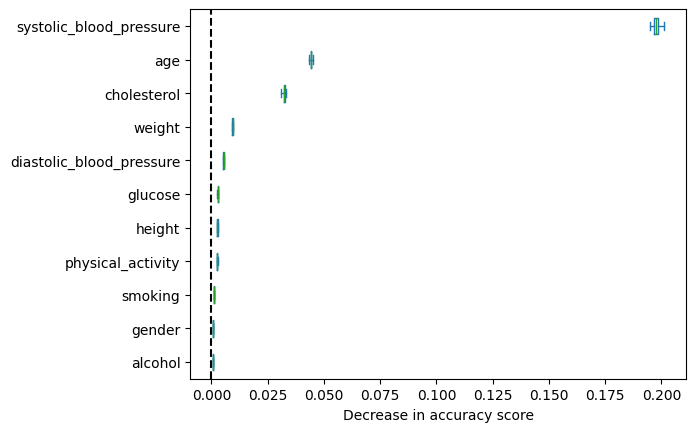


--------> Shap Values


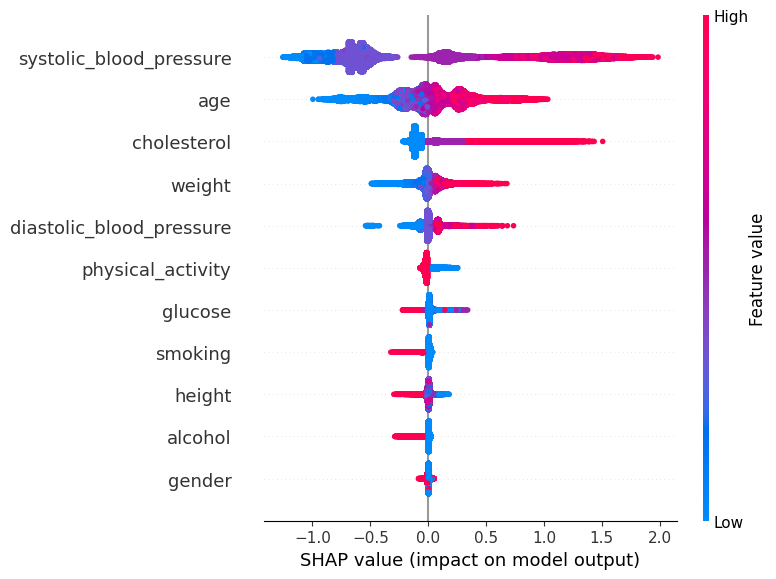

CPU times: user 9min 14s, sys: 7.36 s, total: 9min 21s
Wall time: 46.3 s


In [14]:
%%time
dict_results = automl_lgbm_classifier_cv(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, selection_method=None, target='disease', cv=3, n_trials=10, scoring='roc_auc', direction='maximize')

In [15]:
dict_results['standard_model']

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

In [16]:
dict_results['selected_features_model']

KeyError: 'selected_features_model'

In [ ]:
dict_results['model']

LGBMClassifier(bagging_fraction=0.4828088835812661, bagging_freq=3,
               feature_fraction=0.5122909428348493,
               lambda_l1=0.00478850599445326, lambda_l2=2.5938657307968143e-06,
               learning_rate=0.0965793923393165, metric='binary_logloss',
               min_child_samples=100, n_jobs=-1, num_leaves=19,
               objective='binary', random_state=42, verbosity=-1)

## Simples

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.4, random_state=42)

In [ ]:
y_test.head()

,disease
15944,1
53699,0
15662,0
51429,1
41727,0


In [ ]:
def fit_lgbm_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, target='target', selected_features=None, params=None, random_state=42):

    if selected_features:

        X_train = X_train.loc[:, selected_features]
        X_valid = X_valid.loc[:, selected_features]
        X_test = X_test.loc[:, selected_features]

    cat_columns = X_train.select_dtypes(include='object')

    if any(cat_columns):

        print('---------------> Feature Engineering')
        
        X_train[cat_columns] = X_train[cat_columns].astype("category")
        X_valid[cat_columns] = X_valid[cat_columns].astype("category")
        X_test[cat_columns] = X_test[cat_columns].astype("category")

    print('---------------> Modeling')

    init_params = {'verbosity': -1, 'random_state': random_state, 'n_jobs': -1}
    
    if params:
        
        init_params.update(params)

    model = LGBMClassifier(**init_params)

    model.fit(X_train, y_train[target])

    y_train['prob'] = model.predict_proba(X_train)[:, 1]
    
    y_valid['prob'] = model.predict_proba(X_valid)[:, 1]
    
    y_test['prob'] = model.predict_proba(X_test)[:, 1]

    dict_train_results = get_classification_metrics(y_train, target, decimals=2)
    dict_valid_results = get_classification_metrics(y_valid, target, decimals=2)
    dict_test_results = get_classification_metrics(y_test, target, decimals=2)
    

    print('---------------> Metrics')

    print(f"Training    ROC AUC: {dict_train_results['ROC AUC']}, KS: {dict_train_results['KS']}")
    print(f"Validation  ROC AUC: {dict_valid_results['ROC AUC']}, KS: {dict_valid_results['KS']}")
    print(f"Testing     ROC AUC: {dict_test_results['ROC AUC']}, KS: {dict_test_results['KS']}")
    
    return model

In [ ]:
fit_lgbm_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, target='disease', selected_features=None, params=None, random_state=42)

---------------> Modeling
---------------> Metrics
Training    ROC AUC: 0.83, KS: 0.5
Validation  ROC AUC: 0.8, KS: 0.48
Testing     ROC AUC: 0.81, KS: 0.5


LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

In [ ]:
def tune_params_lgbm_classifier(X_train, y_train, X_valid, y_valid, selected_features=None, n_trials=100, target='target', direction='maximize', random_state=42):

    if selected_features:

        X_train = X_train.loc[:, selected_features]
        X_valid = X_valid.loc[:, selected_features]
    
    def objective(trial):
    
        param = {
            "verbosity": -1, 
            "random_state": random_state, 
            "n_jobs": -1,
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
        }
        
        model = LGBMClassifier(**param)
        model.fit(X_train, y_train[target])

        y_valid['prob'] = model.predict_proba(X_valid)[:, 1]

        score = metrics.roc_auc_score(y_valid[target], y_valid['prob'])
    
        return score
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)

    best_params = {'verbosity': -1, 'random_state': random_state, 'n_jobs': -1}
    best_params.update(study.best_params)
    
    return best_params

In [ ]:
def automl_lgbm_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, selection_method='sfm', target='target', n_trials=100, direction='maximize'):

    dict_results = {}
    
    print('--------> Standard Model')

    standard_model = fit_lgbm_classifier(
        X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, X_test=X_test, y_test=y_test, selected_features=None, target=target, random_state=random_state)

    dict_results['standard_model'] = standard_model

    if selection_method == 'sfm':

        print('\n--------> Feature Selection', '\n---------------> Select From Model')
        
        list_selected_features = select_from_model(estimator=LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1), X_train=X_train, y_train=y_train, target=target)

        dict_results['selected_features'] = list_selected_features

        selected_features_model = fit_lgbm_classifier(
            X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, X_test=X_test, y_test=y_test, selected_features=list_selected_features, target=target, random_state=random_state)
    
        dict_results['selected_features_model'] = selected_features_model
    
    elif selection_method == 'boruta':

        print('\n--------> Feature Selection', '\n---------------> Boruta Shap')

        list_selected_features = boruta_shap_classification(
            X_train=X_train, y_train=y_train, model=LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1), 
            n_trials=100, sample=False, train_or_test='test', normalize=True, verbose=False)

        dict_results['selected_features'] = list_selected_features

        selected_features_model = fit_lgbm_classifier(
            X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, X_test=X_test, y_test=y_test, 
            selected_features=list_selected_features, target=target, random_state=random_state)
    
        dict_results['selected_features_model'] = selected_features_model
    
    else:

        list_selected_features = None

    print('\n--------> Hyperparameter Tuning')
    
    params = tune_params_lgbm_classifier(
        X_train, y_train, X_valid, y_valid, selected_features=list_selected_features, n_trials=n_trials, 
        target=target, direction=direction, random_state=random_state)

    dict_results['best_params'] = params
    
    model = fit_lgbm_classifier(
        X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, X_test=X_test, y_test=y_test, 
        selected_features=list_selected_features, target=target, random_state=random_state, params=params)

    dict_results['model'] = model
    
    print('\n--------> Feature Importance')
    
    df_imp = get_tree_feature_importance(model, X_train, selected_features=list_selected_features)

    dict_results['feature_importance'] = df_imp

    print('\n--------> Permutation Importance')

    df_perm = get_permutation_importance(model, X_test, y_test, target=target, selected_features=list_selected_features, random_state=42, n_repeats=5, scoring='roc_auc')

    dict_results['permutation_importance'] = df_perm
    
    print('\n--------> Shap Values')
    
    get_tree_summary_plot(model, X_train, selected_features=list_selected_features)

    return dict_results

--------> Standard Model
---------------> Modeling
---------------> Metrics
Training    ROC AUC: 0.83, KS: 0.5
Validation  ROC AUC: 0.8, KS: 0.48
Testing     ROC AUC: 0.81, KS: 0.5

--------> Hyperparameter Tuning
---------------> Modeling
---------------> Metrics
Training    ROC AUC: 0.82, KS: 0.49
Validation  ROC AUC: 0.8, KS: 0.48
Testing     ROC AUC: 0.81, KS: 0.49

--------> Feature Importance


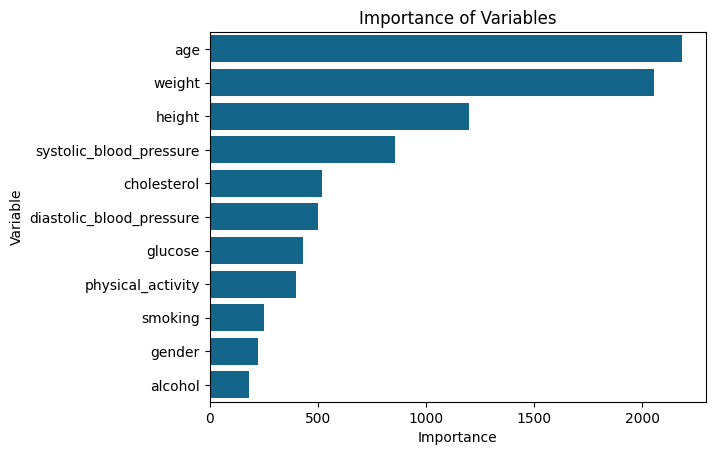


--------> Permutation Importance


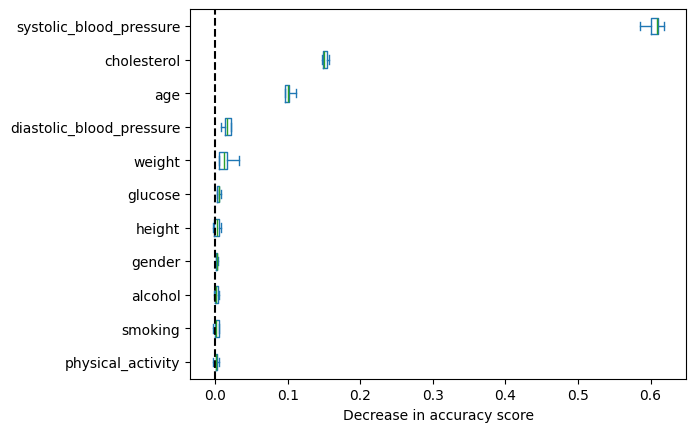


--------> Shap Values


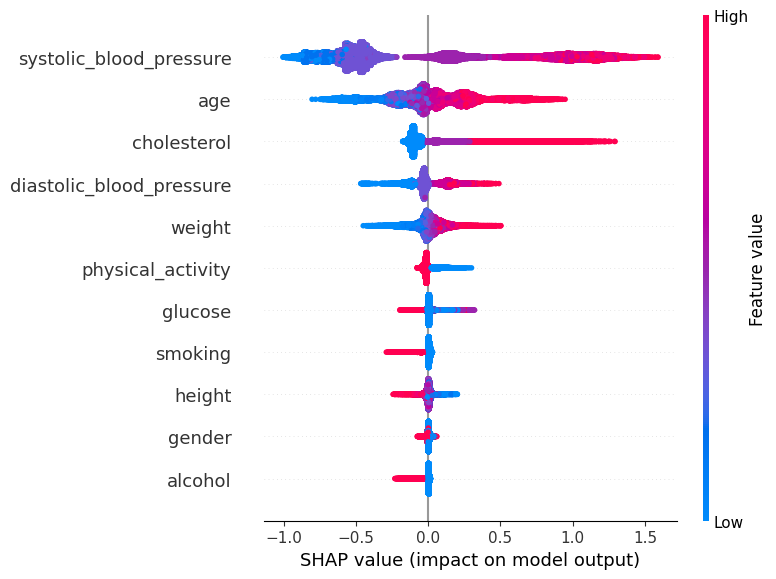

In [ ]:
dict_results = automl_lgbm_classifier(X_train, y_train, X_valid, y_valid, X_test, y_test, selection_method=None, target='disease', n_trials=10, direction='maximize')